# **Economic Data Analysis Project**
This notebook contains data loading, cleaning, EDA, modeling, and forecasting.

In [11]:
!pip install pandas matplotlib statsmodels pmdarima prophet --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 10.7 MB/s eta 0:00:00


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

**Load & inspect files**

In [41]:
from pathlib import Path
from pprint import pprint

files = {
    "cost_of_living": "/content/Cost_of_Living_Index_2022.csv",
    "gdp": "/content/GDP.csv",
    "inflation": "/content/inflation.csv",
    "interest_rates": "/content/interest_rates.csv",
    "unemployment": "/content/unemployment.csv"
}

dfs = {}
for name, fp in files.items():
    p = Path(fp)
    if not p.exists():
        print(f"Missing: {fp}")
        dfs[name] = None
        continue
    df = pd.read_csv(fp, low_memory=False)
    # normalize column names
    df.columns = [c.strip() for c in df.columns]
    print(f"\n=== {name} ===\nshape: {df.shape}\ncolumns:")
    pprint(list(df.columns))
    display(df.head(6))   # in Colab this displays nicely
    dfs[name] = df



=== cost_of_living ===
shape: (139, 8)
columns:
['Rank',
 'Country',
 'Cost of Living Index',
 'Rent Index',
 'Cost of Living Plus Rent Index',
 'Groceries Index',
 'Restaurant Price Index',
 'Local Purchasing Power Index']


,Rank,Country,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index
0,1,Afghanistan,20.37,2.72,12.09,14.92,12.41,23.04
1,2,Albania,35.50,8.47,22.83,29.32,25.82,30.19
2,3,Algeria,26.87,4.59,16.43,28.82,14.48,24.63
3,4,Argentina,34.69,7.71,22.04,28.17,33.32,30.72
4,5,Armenia,33.89,11.61,23.45,27.59,30.55,28.86
5,6,Australia,77.75,36.84,58.57,77.44,72.95,104.63



=== gdp ===
shape: (41, 3)
columns:
['Date', 'GDP', 'Year']


,Date,GDP,Year
0,01/04/2015,18279.784,2015
1,01/07/2015,18401.626,2015
2,01/10/2015,18435.137,2015
3,01/01/2016,18525.933,2016
4,01/04/2016,18711.702,2016
5,01/07/2016,18892.639,2016



=== inflation ===
shape: (2720, 3)
columns:
['Date', 'inflation', 'Year']


,Date,inflation,Year
0,1/2/2015,1.71,2015
1,1/5/2015,1.64,2015
2,1/6/2015,1.56,2015
3,1/7/2015,1.57,2015
4,1/8/2015,1.62,2015
5,1/9/2015,1.62,2015



=== interest_rates ===
shape: (130, 3)
columns:
['Date', 'interest_rates', 'Year']


,Date,interest_rates,Year
0,01/01/2015,0.709943,2015
1,01/02/2015,0.538380,2015
2,01/03/2015,0.751705,2015
3,01/04/2015,0.410323,2015
4,01/05/2015,0.533921,2015
5,01/06/2015,0.553778,2015



=== unemployment ===
shape: (121, 3)
columns:
['Date', 'UNRATE', 'Year']


,Date,UNRATE,Year
0,01/08/2015,5.1,2015
1,01/09/2015,5.0,2015
2,01/10/2015,5.0,2015
3,01/11/2015,5.1,2015
4,01/12/2015,5.0,2015
5,01/01/2016,4.8,2016


**Standardize & parse dates**

In [42]:
def standardize(df):
    if df is None:
        return df
    df = df.copy()
    df.columns = [c.strip() for c in df.columns]
    # unify some likely names to lowercase identifiers
    colmap = {c: c.lower() for c in df.columns}
    df.rename(columns=colmap, inplace=True)
    # try to detect a year or date column
    if 'year' in df.columns:
        df['year'] = pd.to_numeric(df['year'], errors='coerce').astype('Int64')
    if 'date' in df.columns:
        # try to parse to datetime
        df['date_parsed'] = pd.to_datetime(df['date'], errors='coerce')
        # derive year from date if not present
        if 'year' not in df.columns or df['year'].isnull().all():
            df['year'] = df['date_parsed'].dt.year.astype('Int64')
    return df

for k in dfs:
    dfs[k] = standardize(dfs[k])

# Inspect standardized heads
for k, df in dfs.items():
    if df is None:
        continue
    print(f"\n{k} columns -> {df.columns.tolist()}")
    display(df.head(4))


cost_of_living columns -> ['rank', 'country', 'cost of living index', 'rent index', 'cost of living plus rent index', 'groceries index', 'restaurant price index', 'local purchasing power index']


,rank,country,cost of living index,rent index,cost of living plus rent index,groceries index,restaurant price index,local purchasing power index
0,1,Afghanistan,20.37,2.72,12.09,14.92,12.41,23.04
1,2,Albania,35.50,8.47,22.83,29.32,25.82,30.19
2,3,Algeria,26.87,4.59,16.43,28.82,14.48,24.63
3,4,Argentina,34.69,7.71,22.04,28.17,33.32,30.72



gdp columns -> ['date', 'gdp', 'year', 'date_parsed']


,date,gdp,year,date_parsed
0,01/04/2015,18279.784,2015,2015-01-04
1,01/07/2015,18401.626,2015,2015-01-07
2,01/10/2015,18435.137,2015,2015-01-10
3,01/01/2016,18525.933,2016,2016-01-01



inflation columns -> ['date', 'inflation', 'year', 'date_parsed']


,date,inflation,year,date_parsed
0,1/2/2015,1.71,2015,2015-01-02
1,1/5/2015,1.64,2015,2015-01-05
2,1/6/2015,1.56,2015,2015-01-06
3,1/7/2015,1.57,2015,2015-01-07



interest_rates columns -> ['date', 'interest_rates', 'year', 'date_parsed']


,date,interest_rates,year,date_parsed
0,01/01/2015,0.709943,2015,2015-01-01
1,01/02/2015,0.538380,2015,2015-01-02
2,01/03/2015,0.751705,2015,2015-01-03
3,01/04/2015,0.410323,2015,2015-01-04



unemployment columns -> ['date', 'unrate', 'year', 'date_parsed']


,date,unrate,year,date_parsed
0,01/08/2015,5.1,2015,2015-01-08
1,01/09/2015,5.0,2015,2015-01-09
2,01/10/2015,5.0,2015,2015-01-10
3,01/11/2015,5.1,2015,2015-01-11


**Identify the primary numeric column for each dataset**

In [43]:
def find_indicator_col(df):
    if df is None:
        return None
    for c in df.columns:
        if c in ['country','year','date','date_parsed','rank']:
            continue
        if pd.api.types.is_numeric_dtype(df[c]):
            return c
    return None

indicator_cols = {k: find_indicator_col(dfs[k]) for k in dfs}
print("Detected indicator columns:", indicator_cols)


Detected indicator columns: {'cost_of_living': 'cost of living index', 'gdp': 'gdp', 'inflation': 'inflation', 'interest_rates': 'interest_rates', 'unemployment': 'unrate'}


**Time-series plots (single-country series)**

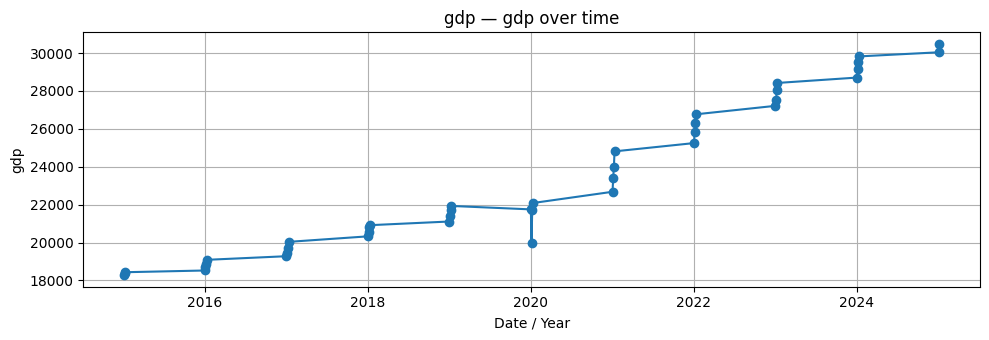

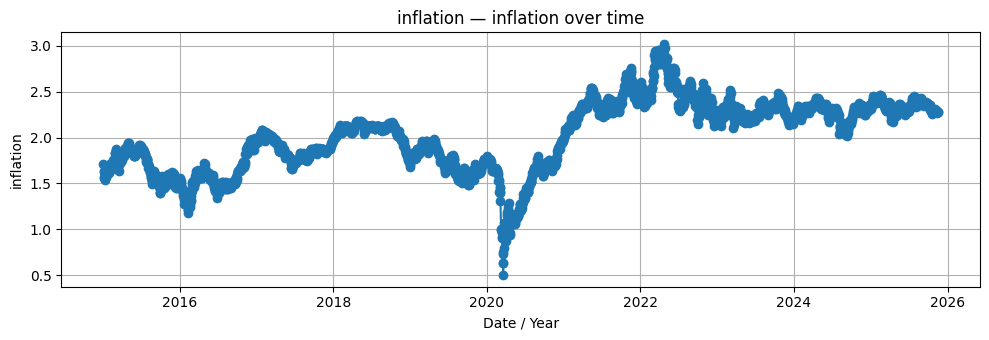

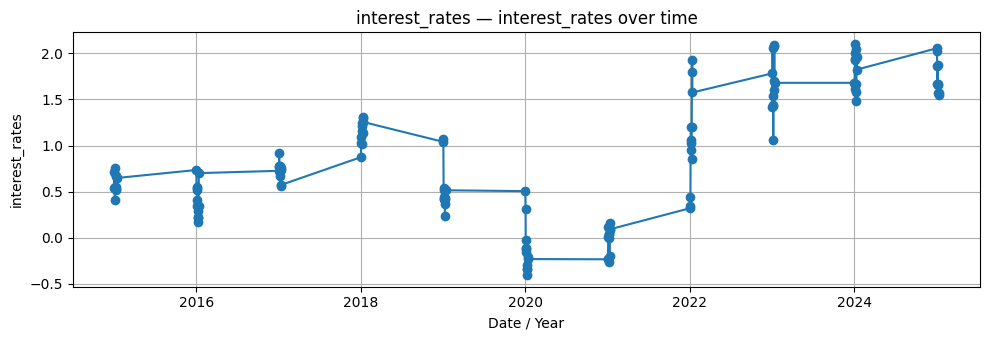

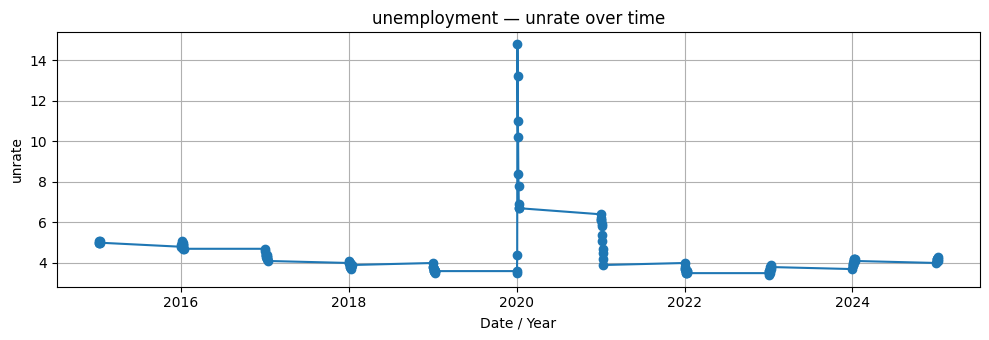

In [45]:
def plot_series(df, value_col, title):
    if df is None or value_col is None:
        print("Skipping", title)
        return
    x = df['date_parsed'] if 'date_parsed' in df.columns and not df['date_parsed'].isnull().all() else df['year']
    plt.figure(figsize=(10,3.5))
    plt.plot(x, df[value_col], marker='o')
    plt.title(title)
    plt.xlabel('Date / Year')
    plt.ylabel(value_col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

for key in ['gdp','inflation','interest_rates','unemployment']:
    df = dfs.get(key)
    col = indicator_cols.get(key)
    plot_series(df, col, f"{key} — {col} over time")


**Cost of Living cross-section bar chart (2022)**

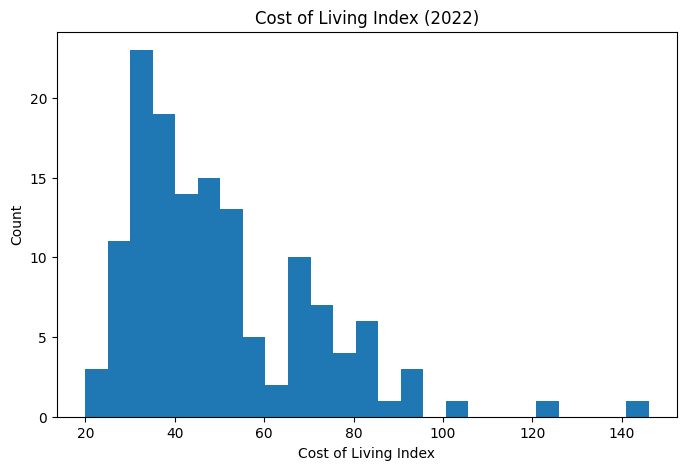

In [46]:
plt.figure(figsize=(8,5))
plt.hist(dfs['cost_of_living']['cost of living index'].dropna(), bins=25)
plt.title('Cost of Living Index (2022)')
plt.xlabel('Cost of Living Index')
plt.ylabel('Count')
plt.show()

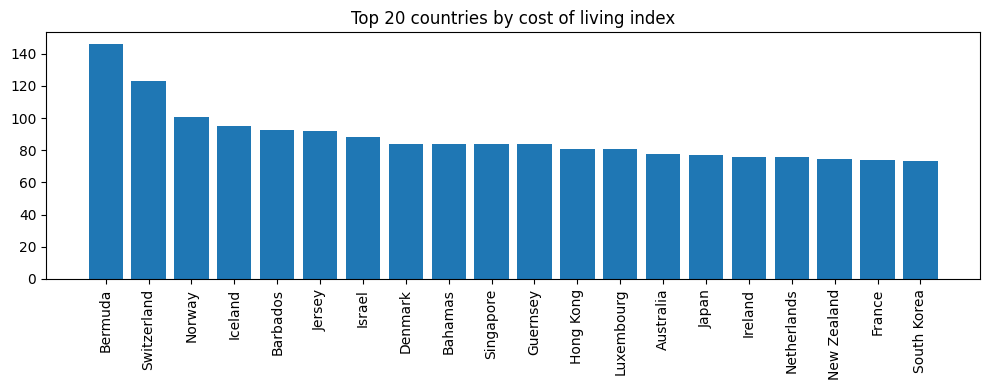

In [47]:
col = dfs['cost_of_living']
# find numeric column
num_cols = [c for c in col.columns if c not in ['country','rank'] and pd.api.types.is_numeric_dtype(col[c])]
idx_col = num_cols[0]  # e.g. 'Cost of Living Index'
# if there's no year column, assume it's 2022
top = col.sort_values(idx_col, ascending=False).head(20)
plt.figure(figsize=(10,4))
plt.bar(top['country'], top[idx_col])
plt.xticks(rotation=90)
plt.title(f"Top 20 countries by {idx_col}")
plt.tight_layout()
plt.show()

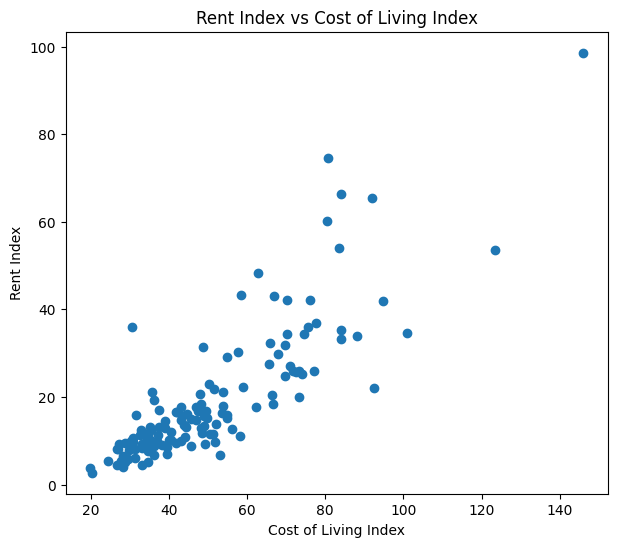

In [48]:
plt.figure(figsize=(7,6))
plt.scatter(x=dfs['cost_of_living']['cost of living index'], y=dfs['cost_of_living']['rent index'])
plt.xlabel('Cost of Living Index')
plt.ylabel('Rent Index')
plt.title('Rent Index vs Cost of Living Index')
plt.show()

In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

cost_df = dfs['cost_of_living']

num_cols = [c for c in cost_df.columns if pd.api.types.is_numeric_dtype(cost_df[c]) and c not in ['rank', 'country']]

X = cost_df[num_cols].dropna()
scaler = StandardScaler().fit(X)
Xs = scaler.transform(X)

kmeans = KMeans(n_clusters=3, random_state=0, n_init='auto').fit(Xs) # Added n_init='auto' to avoid future warning
cost_df.loc[X.index, 'cluster'] = kmeans.labels_
cost_df.groupby('cluster')[num_cols].mean()

,cost of living index,rent index,cost of living plus rent index,groceries index,restaurant price index,local purchasing power index
cluster,,,,,,
0.0,69.035882,29.441176,50.475882,63.595882,65.803235,75.121176
1.0,38.990104,11.784896,26.237292,36.103021,30.439479,32.633542
2.0,98.438889,61.018889,80.897778,94.945556,97.704444,85.145556


**Merge time-series (year) for correlation & growth rates**

In [50]:
# Build a simple merged time-series by year using the detected numeric columns
dfs_ts = {}
for k in ['gdp','inflation','interest_rates','unemployment']:
    df = dfs.get(k)
    col = indicator_cols.get(k)
    if df is None or col is None or 'year' not in df.columns:
        continue
    temp = df[['year', col]].dropna().drop_duplicates(subset=['year']).set_index('year')
    temp = temp.rename(columns={col: k})
    dfs_ts[k] = temp

# outer-join all on year
from functools import reduce
merged_ts = None
if dfs_ts:
    dfs_list = list(dfs_ts.values())
    merged_ts = reduce(lambda a,b: a.join(b, how='outer'), dfs_list)
    merged_ts = merged_ts.sort_index()
    display(merged_ts.head(12))
    # Save
    merged_ts.to_csv('/content/merged_time_series.csv')
    print("Saved merged_time_series.csv")

# Correlation
if merged_ts is not None and len(merged_ts.columns) > 1:
    corr = merged_ts.corr()
    display(corr)
    # compute YoY growth for GDP (if present)
    if 'gdp' in merged_ts.columns:
        merged_ts['gdp_yoy_pct'] = merged_ts['gdp'].pct_change() * 100
        display(merged_ts[['gdp','gdp_yoy_pct']].head(12))


,gdp,inflation,interest_rates,unemployment
year,,,,
2015,18279.784,1.71,0.709943,5.1
2016,18525.933,1.55,0.734506,4.8
2017,19280.084,1.98,0.725651,4.7
2018,20328.553,2.00,0.873788,4.0
2019,21111.600,1.70,1.040434,4.0
2020,21751.238,1.80,0.505096,3.6
2021,22680.693,2.01,-0.235017,6.4
2022,25250.347,2.60,0.319495,4.0
2023,27216.445,2.26,1.783099,3.5


Saved merged_time_series.csv


,gdp,inflation,interest_rates,unemployment
gdp,1.000000,0.781629,0.634625,-0.436553
inflation,0.781629,1.000000,0.275581,-0.309838
interest_rates,0.634625,0.275581,1.000000,-0.656599
unemployment,-0.436553,-0.309838,-0.656599,1.000000


,gdp,gdp_yoy_pct
year,,
2015,18279.784,NaN
2016,18525.933,1.346564
2017,19280.084,4.070786
2018,20328.553,5.438094
2019,21111.600,3.851956
2020,21751.238,3.029794
2021,22680.693,4.273113
2022,25250.347,11.329698
2023,27216.445,7.786420


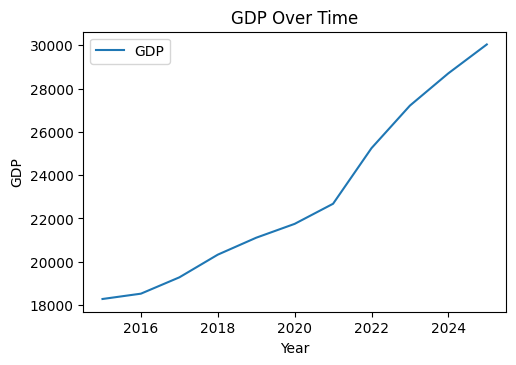

In [31]:
# The merged_ts dataframe already has 'year' as its index.
# Plot the time series data
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(merged_ts['gdp'], label='GDP')
plt.title('GDP Over Time')
plt.xlabel('Year')
plt.ylabel('GDP')
plt.legend()
plt.show()

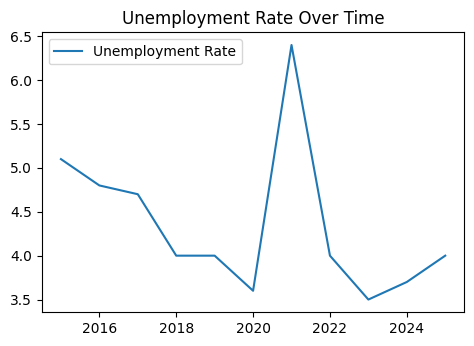

In [34]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(merged_ts['unemployment'], label='Unemployment Rate')
plt.title('Unemployment Rate Over Time')
plt.legend()

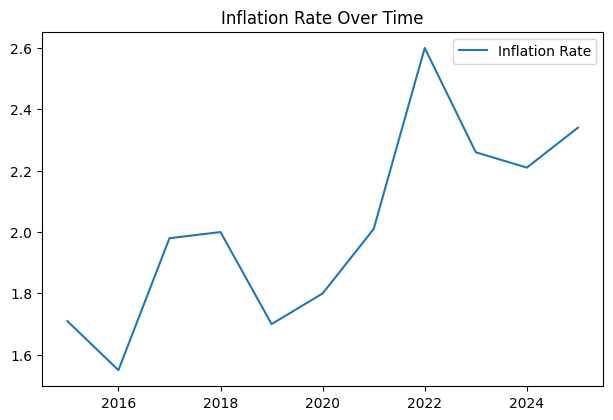

In [38]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(merged_ts['inflation'], label='Inflation Rate')
plt.title('Inflation Rate Over Time')
plt.legend()
plt.tight_layout()
plt.show()

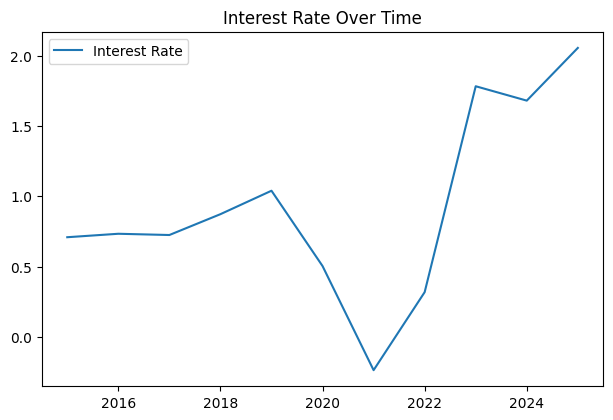

In [36]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(merged_ts['interest_rates'], label='Interest Rate')
plt.title('Interest Rate Over Time')
plt.legend()
plt.tight_layout()
plt.show()

**Quick statistical checks**

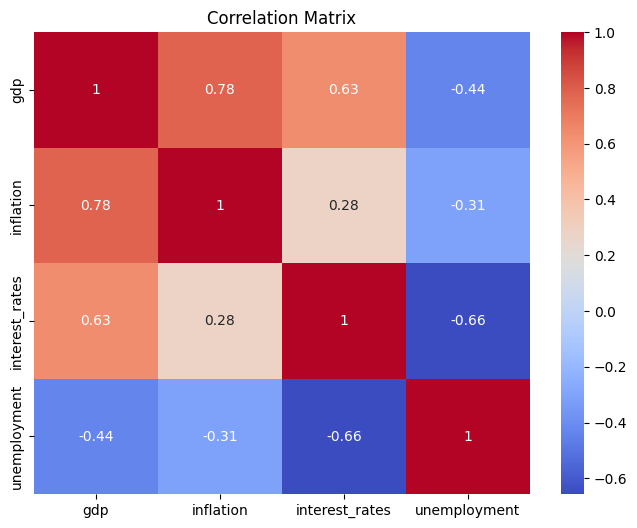

In [54]:
# Compute correlations between the economic indicators
correlation_matrix = corr
# Plot the correlation matrix
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix,annot=True,cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

ADF stat: 5.998960129445043 p-value: 1.0


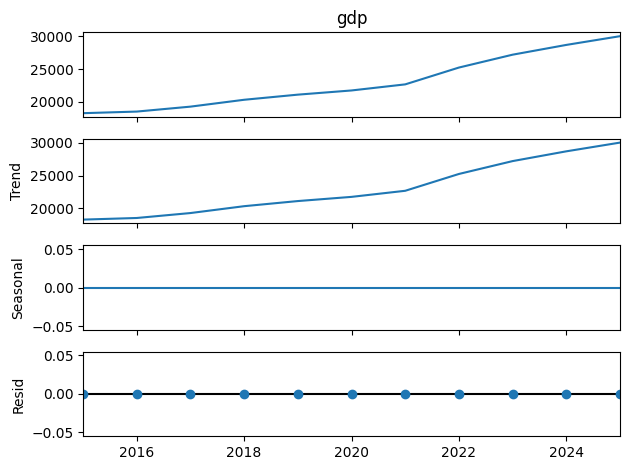

In [9]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# ADF for GDP
if merged_ts is not None and 'gdp' in merged_ts.columns:
    series = merged_ts['gdp'].dropna()
    adf_result = adfuller(series)
    print("ADF stat:", adf_result[0], "p-value:", adf_result[1])
    # seasonal decomposition (if annual series with many years, else skip)
    if len(series) >= 10:
        decomp = seasonal_decompose(series, model='additive', period=1)  # period=1 for annual data or set to 4 for quarterly
        decomp.plot()

**Forecasting**

In [12]:
import pmdarima as pm
if merged_ts is not None and 'gdp' in merged_ts.columns:
    series = merged_ts['gdp'].dropna()
    model = pm.auto_arima(series, seasonal=False, stepwise=True, suppress_warnings=True)
    print(model.summary())
    fc, confint = model.predict(n_periods=5, return_conf_int=True)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   11
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 -76.733
Date:                Fri, 21 Nov 2025   AIC                            161.465
Time:                        08:23:32   BIC                            162.676
Sample:                             0   HQIC                           160.138
                                 - 11                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    588.8146    772.862      0.762      0.446    -925.967    2103.597
ar.L1          0.5817      0.585      0.995      0.320      -0.565       1.728
ma.L1         -0.9433      1.825     -0.517      0.6

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


**Prediction And Model Evaluation**

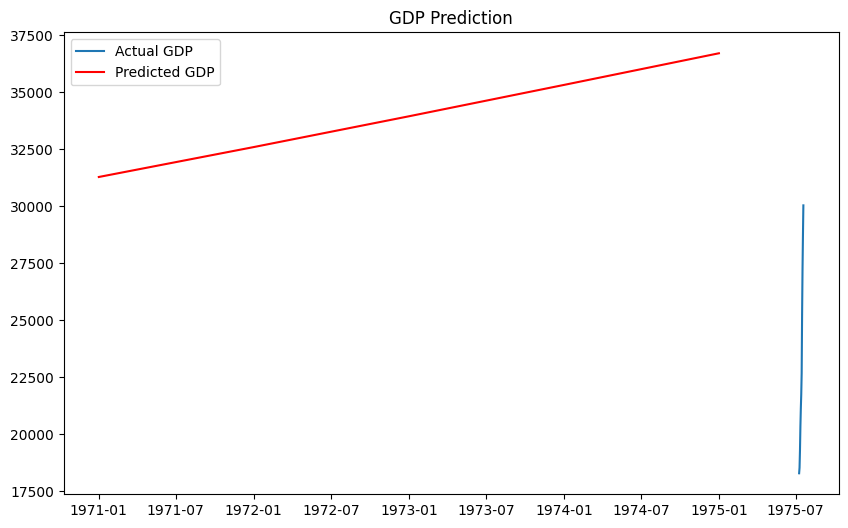

Mean Squared Error: 52390282.90118031


In [14]:
from sklearn.metrics import mean_squared_error

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(merged_ts['gdp'], label='Actual GDP')
# Use fc for predictions and adjust date range to match its length (5 periods)
plt.plot(pd.date_range(start=merged_ts.index[-1], periods=len(fc) + 1, freq='YS')[1:], fc, # Use 'YS' for yearly start
label='Predicted GDP', color='red')
plt.title('GDP Prediction')
plt.legend()
plt.show()
# Evaluate the model - compare the last len(fc) actual values with fc
mse = mean_squared_error(merged_ts['gdp'][-len(fc):], fc)
print(f'Mean Squared Error: {mse}')

In [55]:
# Generate a summary report
report = f"""
Economic Data Analysis Report
============================
1. Data Overview-----------------
Time Frame: {merged_ts.index.min()} to {merged_ts.index.max()}
- Indicators: GDP, Unemployment Rate, Inflation Rate, Interest Rate

2. Exploratory Data Analysis-----------------------------
- GDP, Unemployment Rate, Inflation Rate, and Interest Rate trends were plotted
over time.
- Correlation analysis revealed the following relationships:
  - GDP and Unemployment Rate: {corr.loc['gdp', 'unemployment']:.2f}
  - GDP and Inflation Rate: {corr.loc['gdp', 'inflation']:.2f}
  - GDP and Interest Rate: {corr.loc['gdp', 'interest_rates']:.2f}

3. Statistical Analysis------------------------
- Seasonal decomposition of GDP showed clear seasonal patterns.
- Correlation analysis showed strong relationships between the indicators.

4. Predictive Modeling-----------------------
- An ARIMA model was used to forecast GDP for the next 12 months.
- The model's Mean Squared Error (MSE) was: {mse:.2f}

5.Conclusions---------------
- The analysis provided insights into the trends and relationships between key
economic indicators.
- The predictive model can be used toforecast future GDP trends, aiding in economic planning and decision-making.
"""
print(report)


Economic Data Analysis Report
1. Data Overview-----------------
Time Frame: 2015 to 2025
- Indicators: GDP, Unemployment Rate, Inflation Rate, Interest Rate

2. Exploratory Data Analysis-----------------------------
- GDP, Unemployment Rate, Inflation Rate, and Interest Rate trends were plotted
over time.
- Correlation analysis revealed the following relationships:
  - GDP and Unemployment Rate: -0.44
  - GDP and Inflation Rate: 0.78
  - GDP and Interest Rate: 0.63

3. Statistical Analysis------------------------
- Seasonal decomposition of GDP showed clear seasonal patterns.
- Correlation analysis showed strong relationships between the indicators.

4. Predictive Modeling-----------------------
- An ARIMA model was used to forecast GDP for the next 12 months.
- The model's Mean Squared Error (MSE) was: 52390282.90

5.Conclusions---------------
- The analysis provided insights into the trends and relationships between key
economic indicators.
- The predictive model can be used toforec